In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 15927, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 15927 (delta 20), reused 24 (delta 8), pack-reused 15880
Receiving objects: 100% (15927/15927), 14.66 MiB | 19.55 MiB/s, done.
Resolving deltas: 100% (10915/10915), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [2]:
!pip install -qr requirements.txt
import torch

from IPython.display import Image, clear_output
from utils.downloads import attempt_download

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00
Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3JfDXpJtG3TicyiI06v9")
project = rf.workspace("g-ealn5").project("a-7kprn")
dataset = project.version(1).download("yolov5")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.7 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f80cb112518007ee29ecbbc927fe4957b4251e040dac47431e718b712435de2c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to a-1 in yolov5pytorch:: 100%|██████████| 5000/5000 [00:01<00:00, 4240.31it/s]


In [4]:
%cd /content/yolov5

/content/yolov5


In [5]:
%cat {dataset.location}/data.yaml

names:
- blue
- green
- purple
- red
- yellow
nc: 5
roboflow:
  license: CC BY 4.0
  project: a-7kprn
  url: https://universe.roboflow.com/g-ealn5/a-7kprn/dataset/1
  version: 1
  workspace: g-ealn5
test: ../test/images
train: a-1/train/images
val: a-1/valid/images


In [6]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml
# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [13]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 10 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2023-08-29 04:26:00.797933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 04:26:02.030935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/a-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed

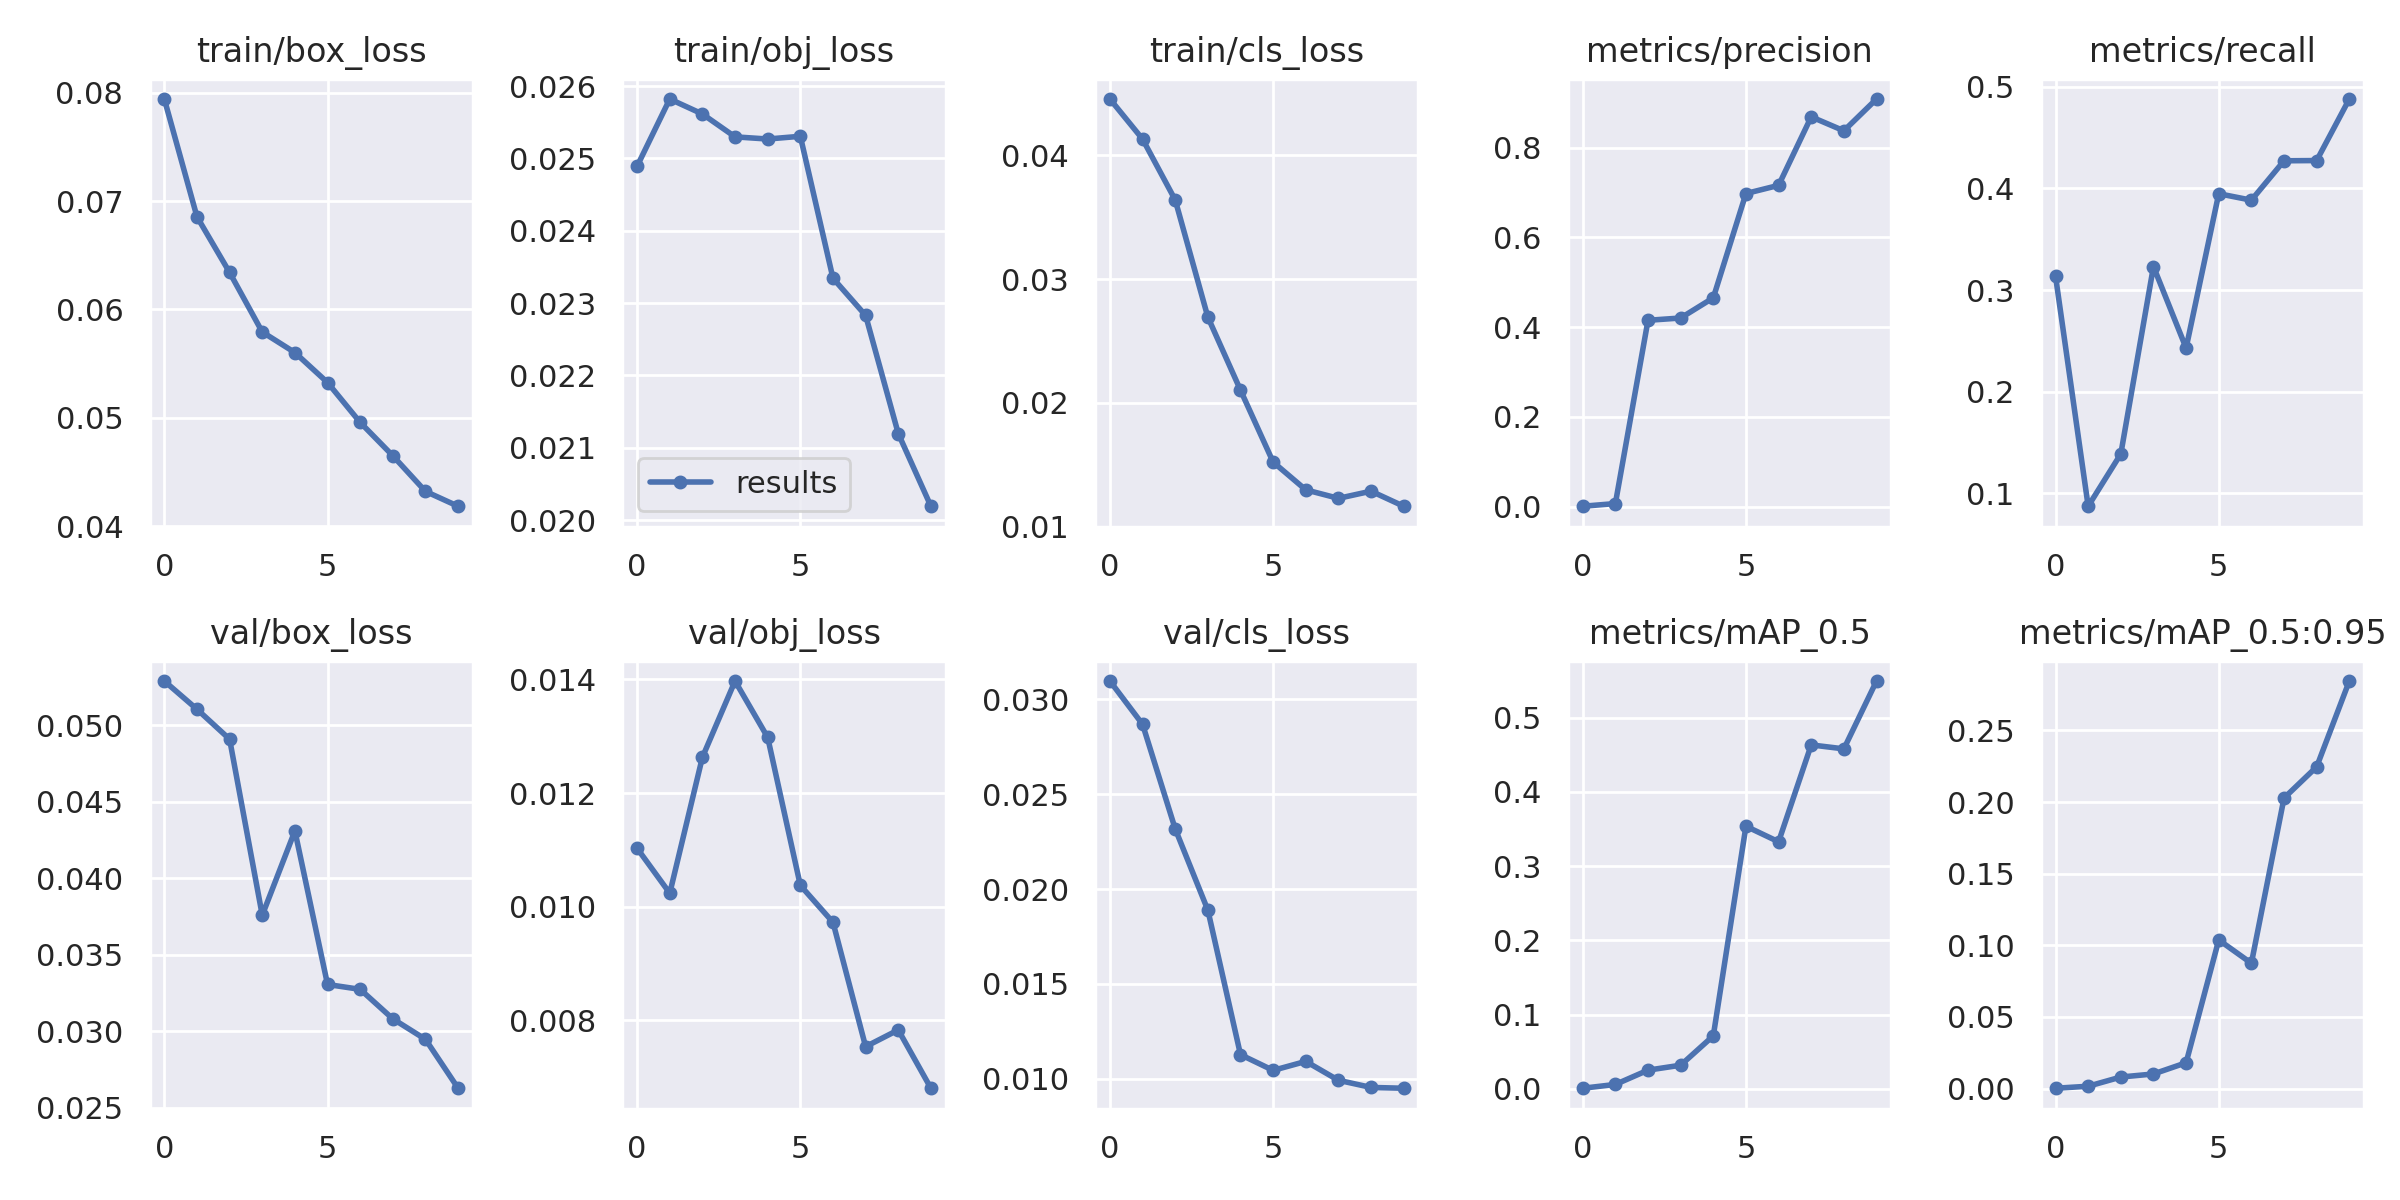

In [14]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


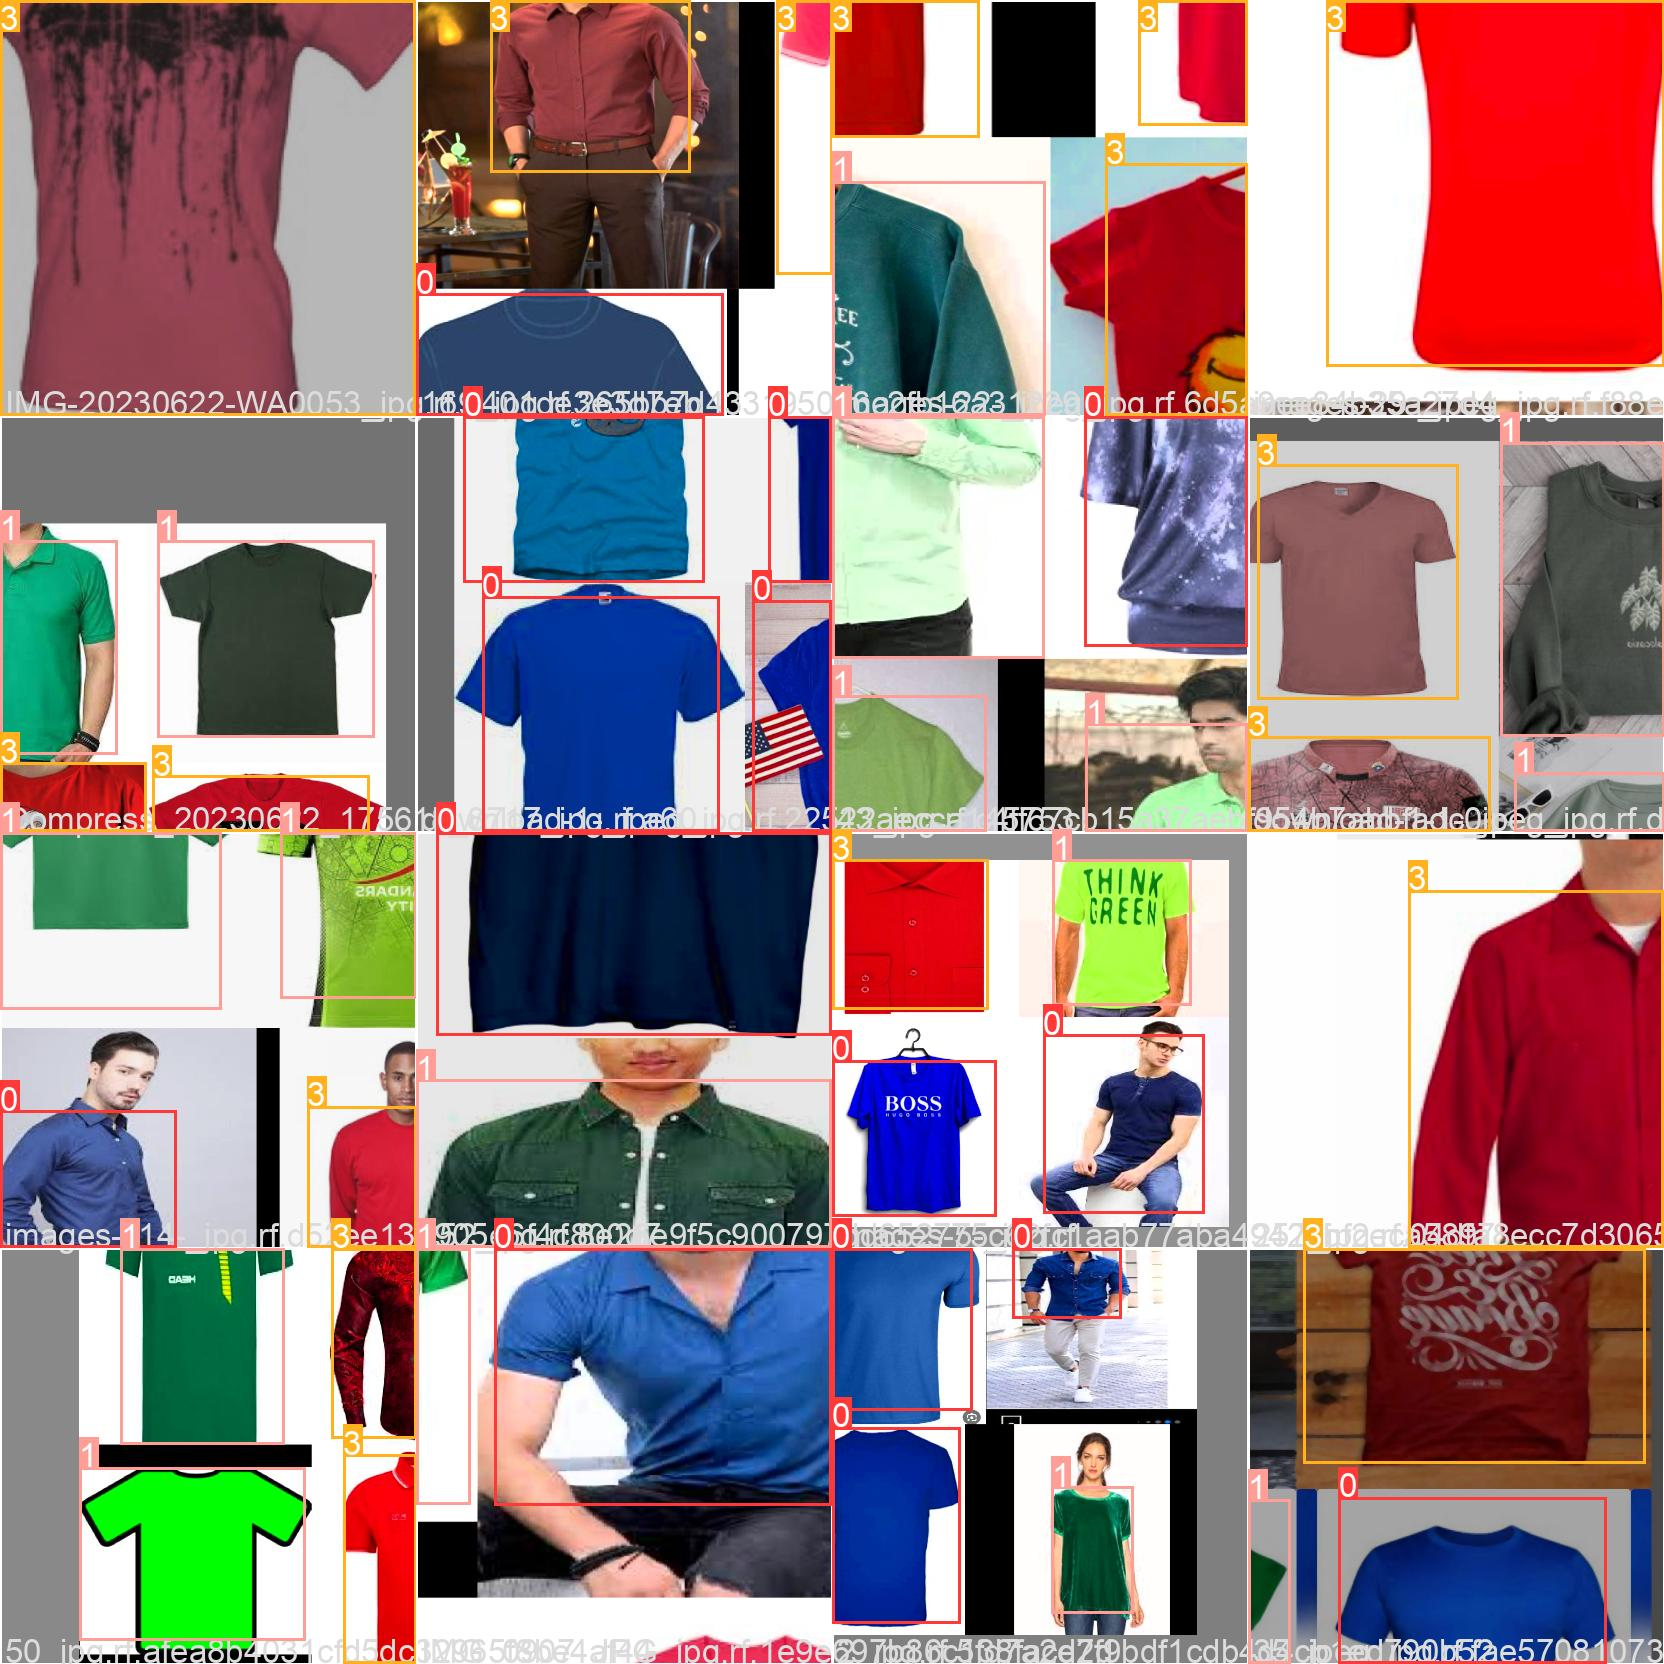

In [15]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


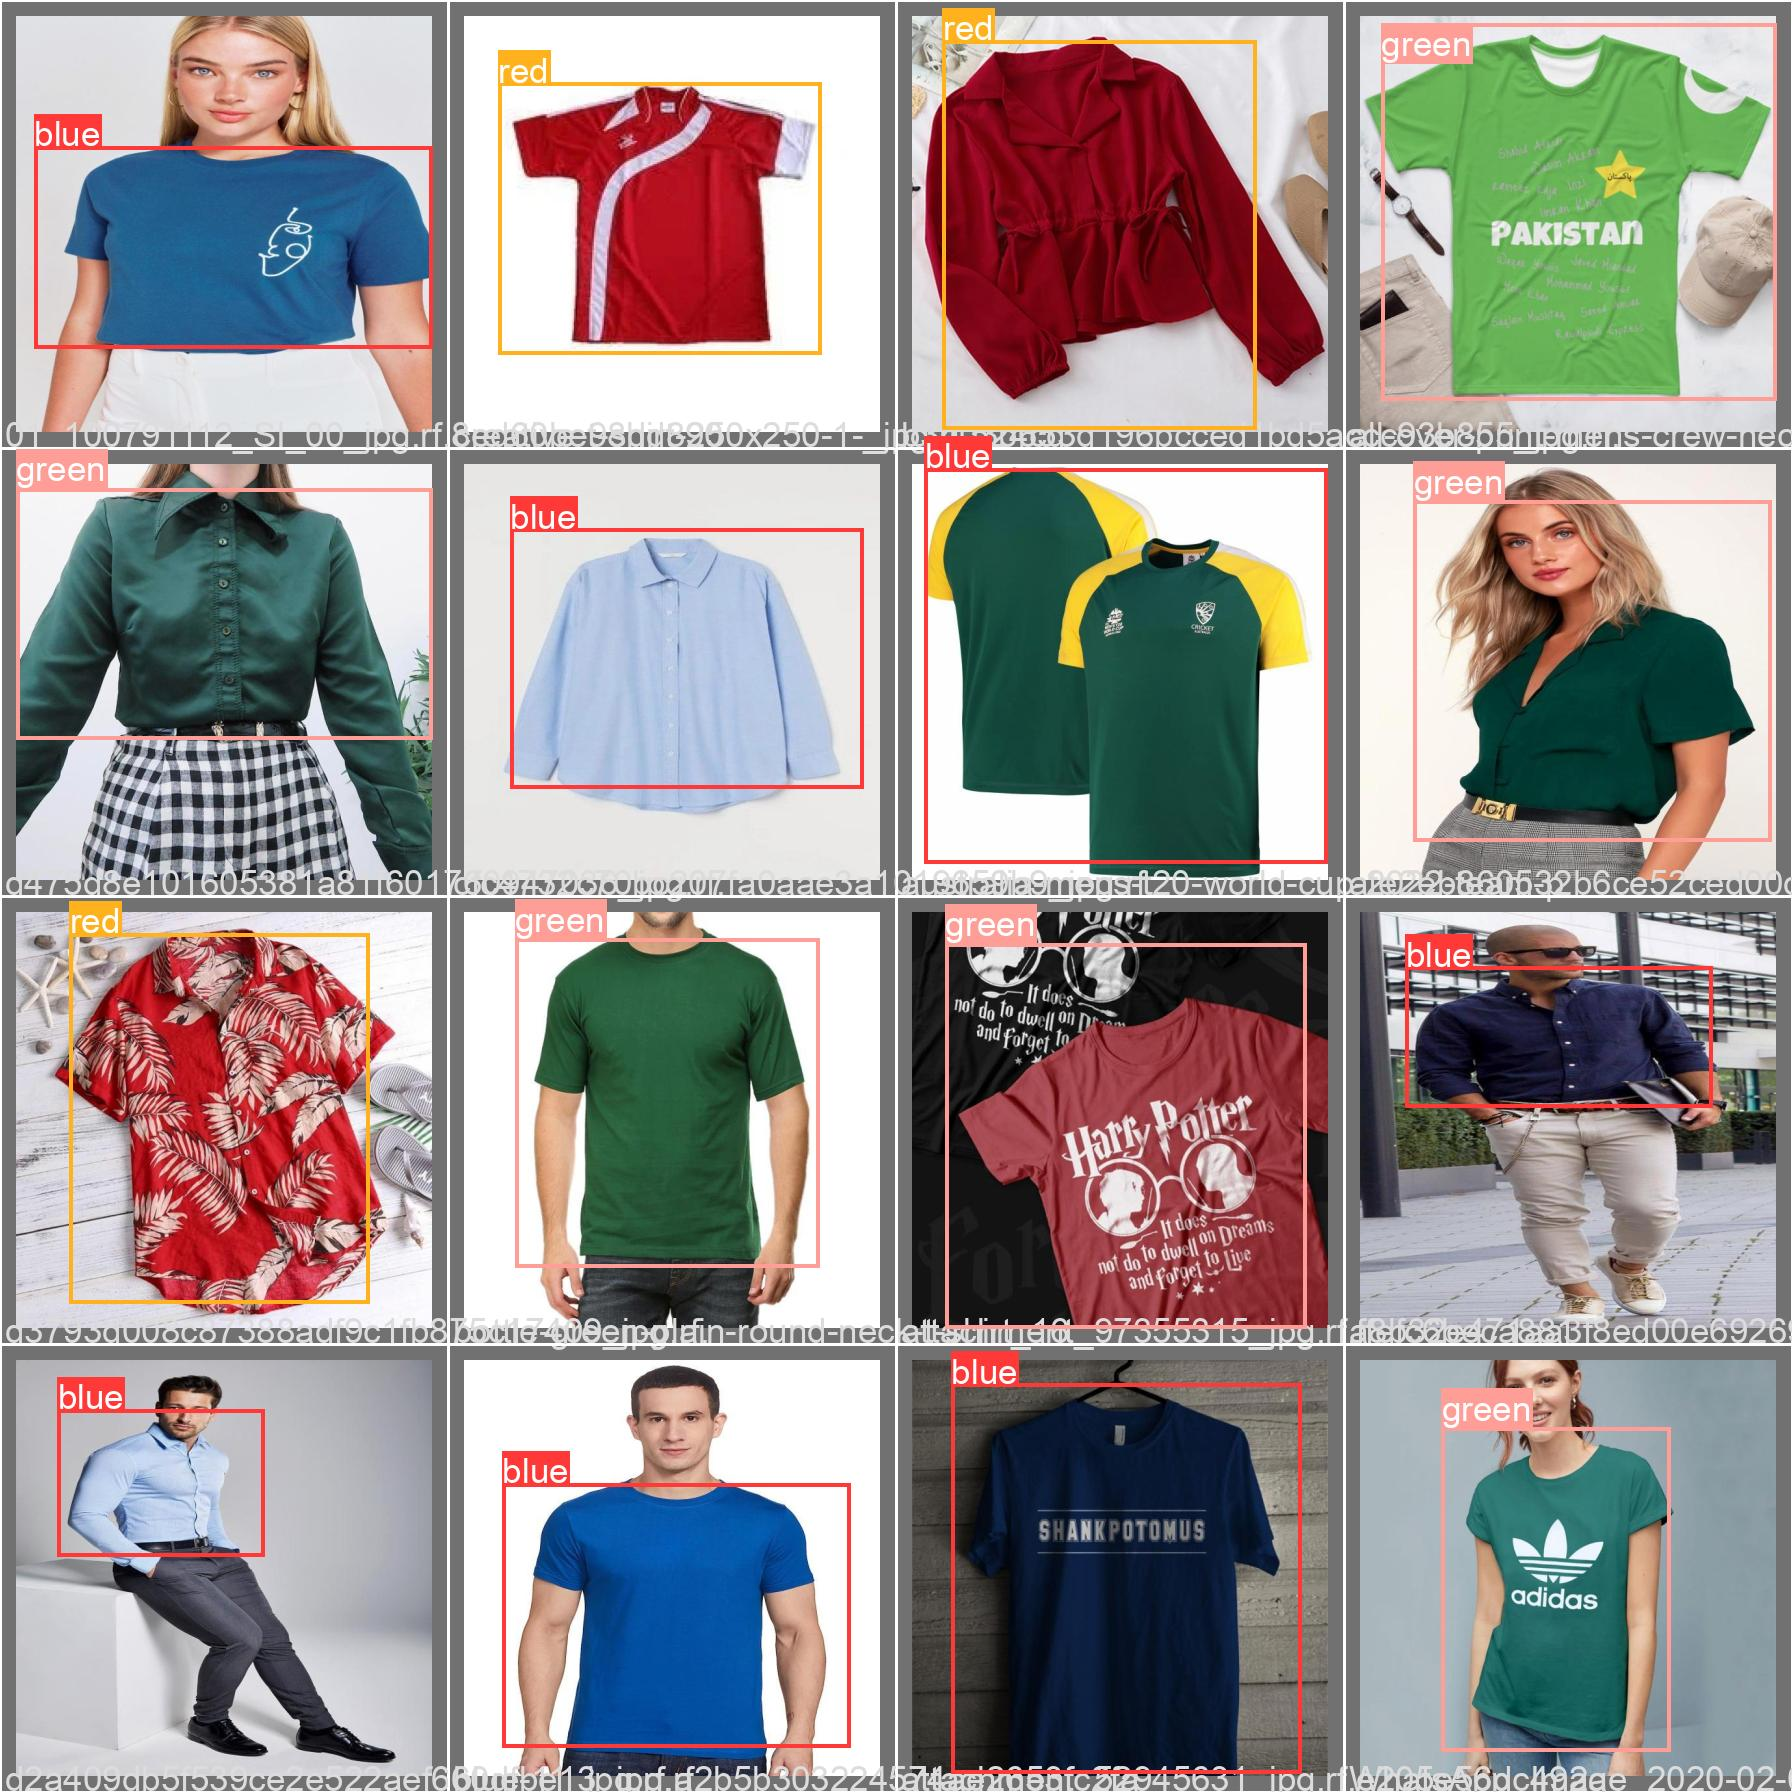

In [16]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

In [24]:
%ls runs/

detect/  train/


In [29]:
%ls runs/train/yolov5s_results2/weights

best.pt  last.pt


In [36]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source ../yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg

/content/yolov5
detect: weights=['runs/train/yolov5s_results2/weights/best.pt'], source=../yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg: 416x416 1 blue, Done. (0.007s)
Speed: 0.5ms pre-process, 7.4ms inference, 78.3ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp10


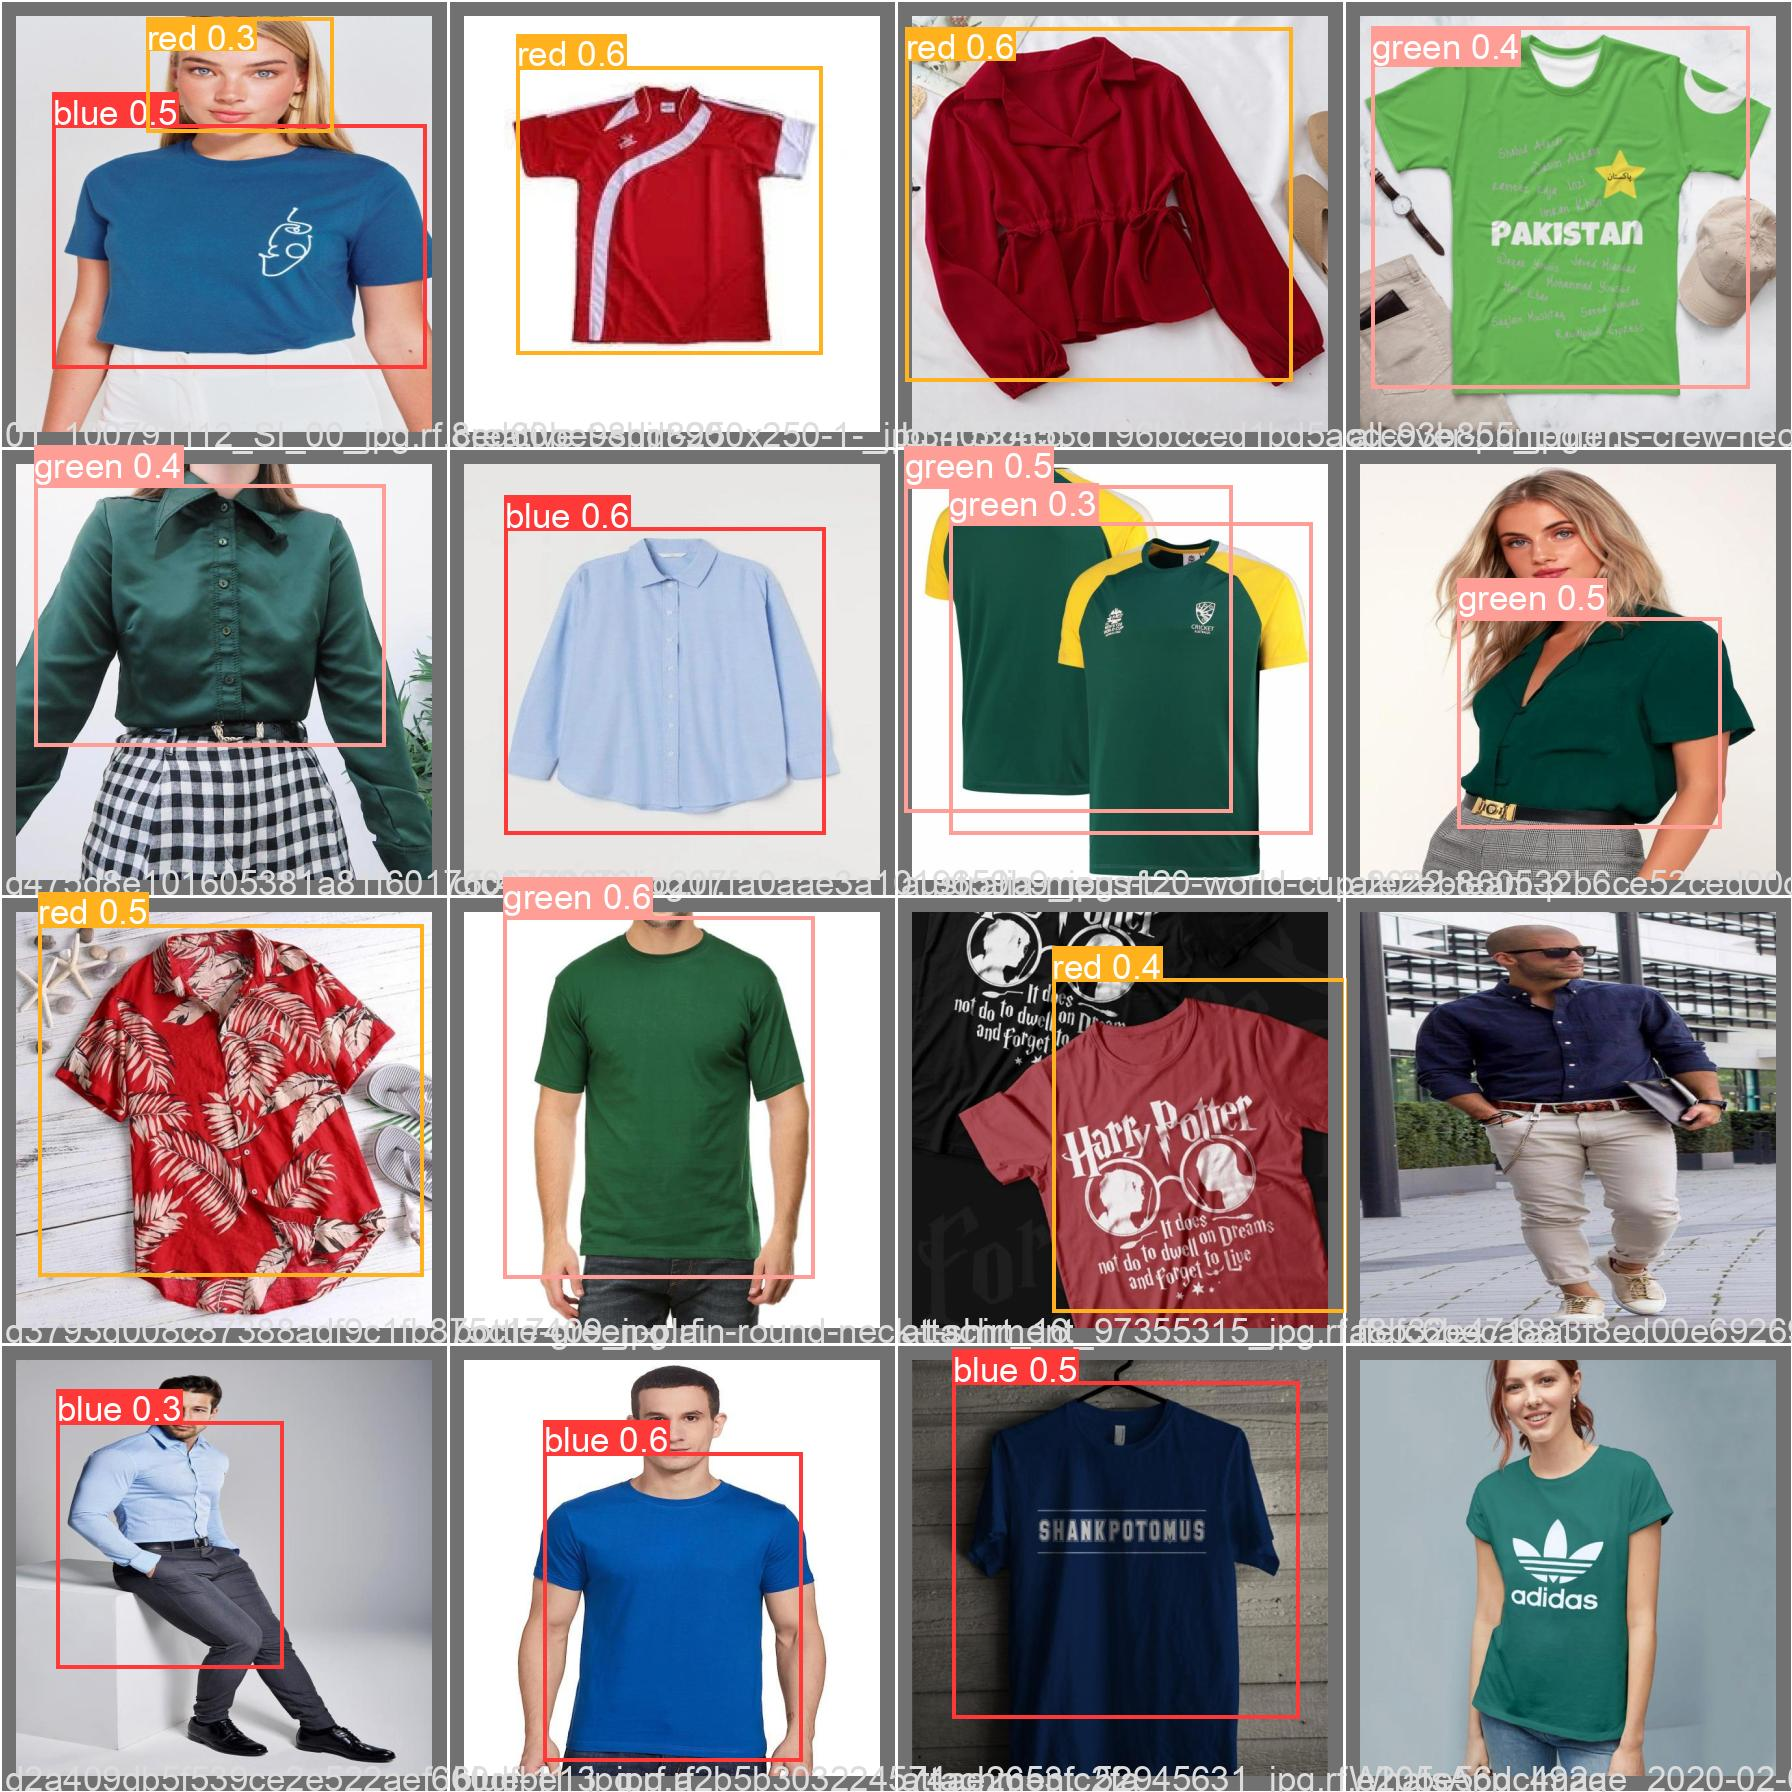

In [38]:

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/train/yolov5s_results2/val_batch0_pred.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

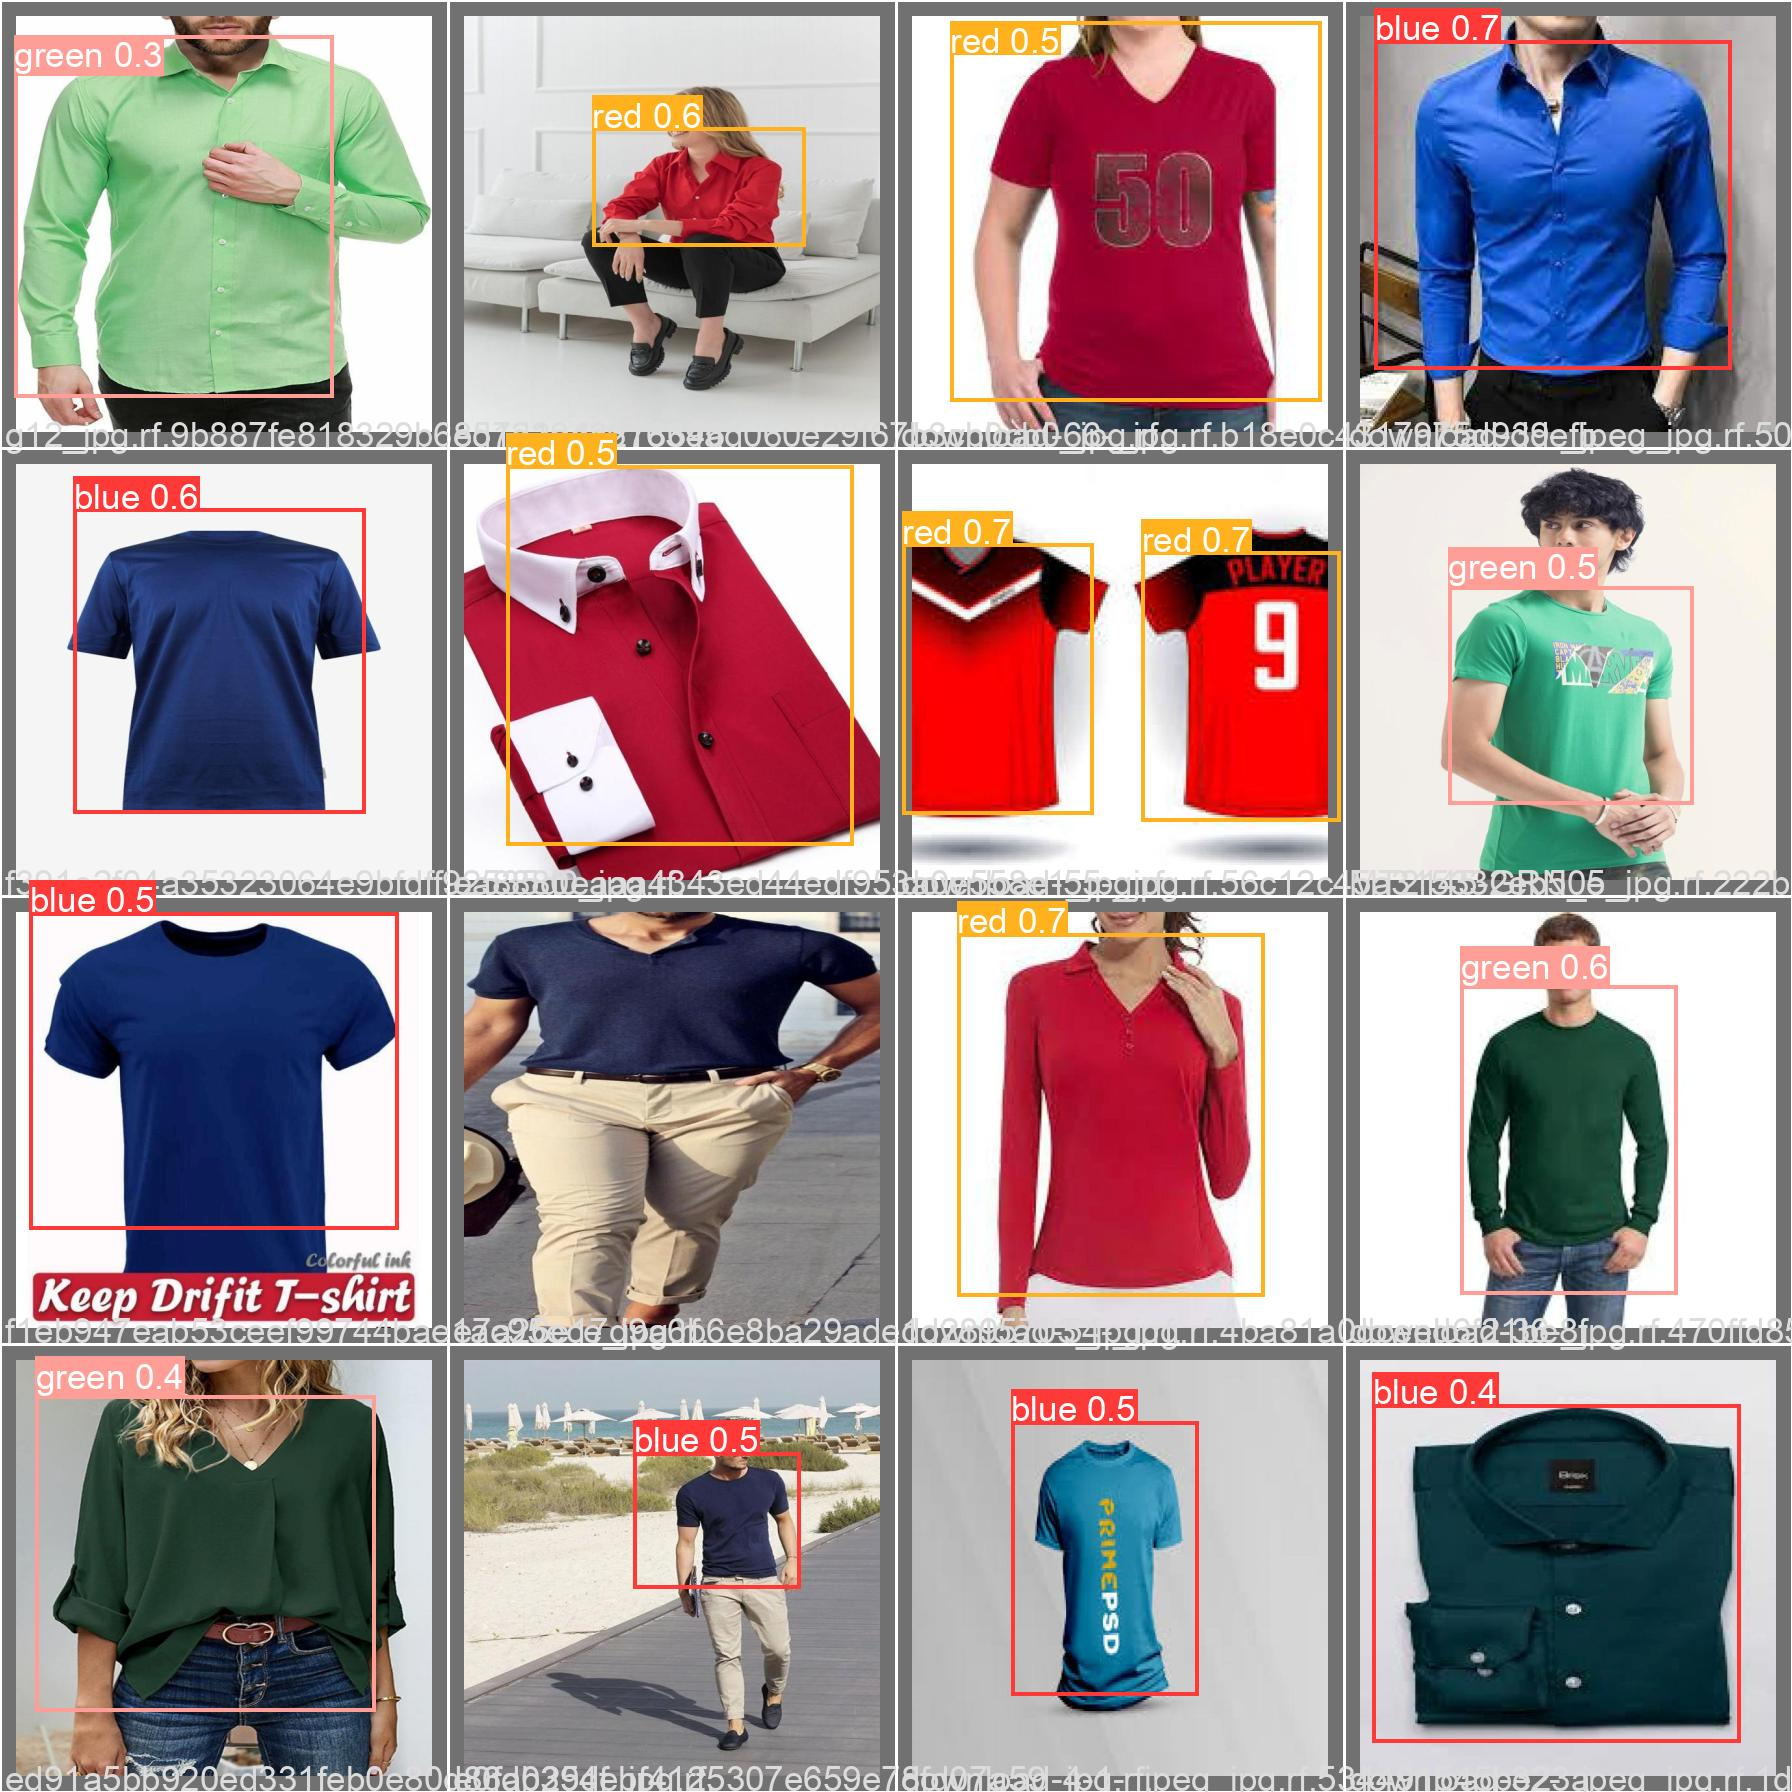

In [40]:

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/train/yolov5s_results2/val_batch1_pred.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

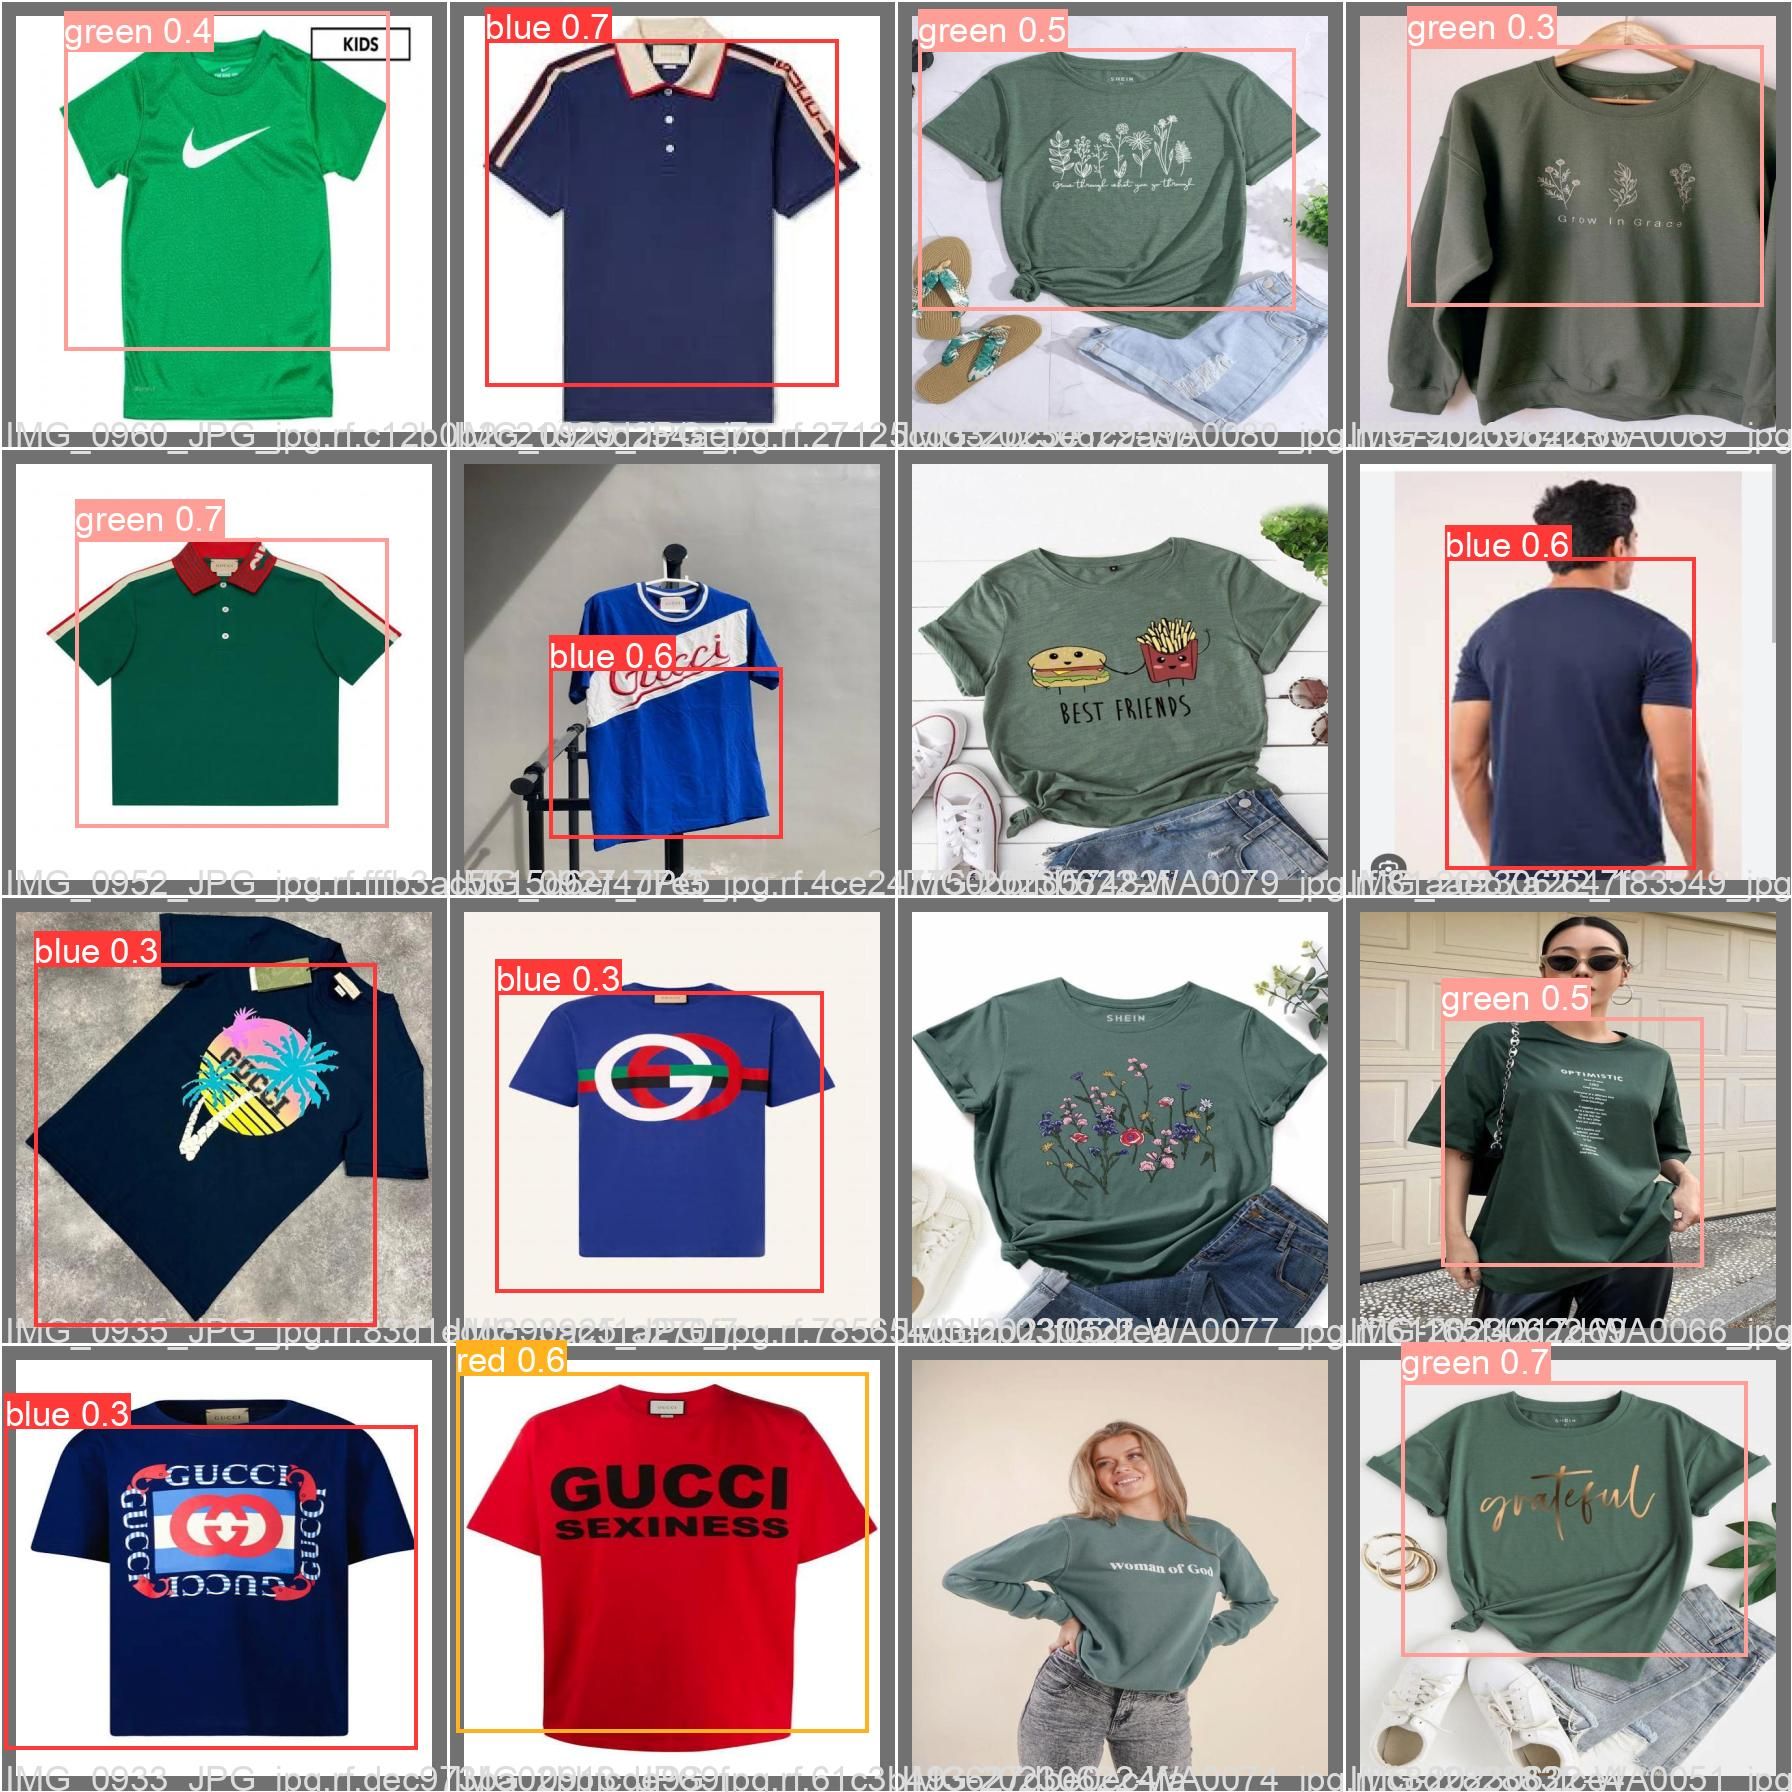

In [42]:

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/train/yolov5s_results2/val_batch2_pred.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [45]:
%cp /content/yolov5/runs/train/yolov5s_results2/weights/best.pt/content/gdrive/My\ Drive

cp: missing destination file operand after '/content/yolov5/runs/train/yolov5s_results2/weights/best.pt/content/gdrive/My Drive'
Try 'cp --help' for more information.
